In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Препрцессинг текста. Очистка и перевод в один регистр

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# чтение датасета
df_train = pd.read_csv('/content/drive/MyDrive/учеба/dataanal/nlp/emotions/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/учеба/dataanal/nlp/emotions/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/учеба/dataanal/nlp/emotions/test.txt', names=['Text', 'Emotion'], sep=';')
#Обработка текста
X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

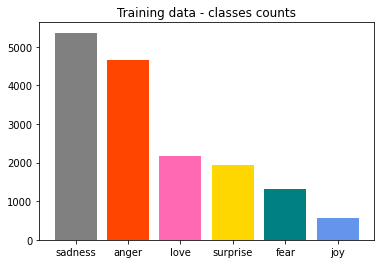

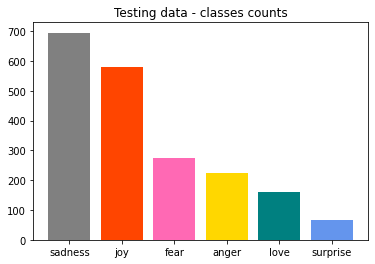

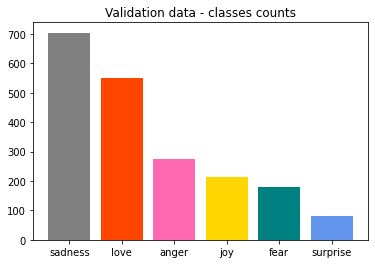

In [5]:
# Посчитаем классы
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [6]:
X=df_train['Text']

lst=[]
for i in X:
  lst.append(len(i))

len1=pd.DataFrame(lst)
len1.describe()



,0
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [7]:
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

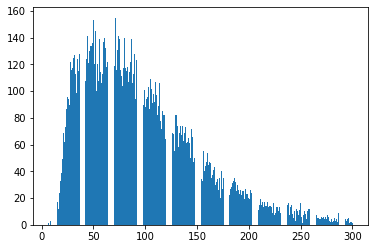

In [8]:
plt.bar(range(7,301),cts)
plt.show()

Токенизация текста

In [9]:
tokenizer=Tokenizer(15212,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X)

In [10]:
len(tokenizer.word_index)

15213

подготовка к обучению

In [11]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post')

df_train['Emotion']=df_train.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

Y_train=df_train['Emotion'].values



In [12]:
Y_train_f=to_categorical(Y_train)

Y_train_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [13]:
X_val=df_val['Text']
Y_val=df_val.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='post')

Y_val_f=to_categorical(Y_val)

Y_val_f[:6]



array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [55]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout, Flatten

модель LSTM

In [38]:
model=Sequential()
model.add(Embedding(15212,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            973568    
                                                                 
 dropout_1 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 1,479,174
Trainable params: 1,479,174
No

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
history=model.fit(X_train_pad,Y_train_f,epochs=12,validation_data=(X_val_pad,Y_val_f))

Epoch 1/12
500/500 [==============================] - 261s 509ms/step - loss: 1.2610 - accuracy: 0.5059 - val_loss: 0.7311 - val_accuracy: 0.7050
Epoch 2/12
500/500 [==============================] - 255s 510ms/step - loss: 0.5532 - accuracy: 0.7926 - val_loss: 0.3768 - val_accuracy: 0.8720
Epoch 3/12
500/500 [==============================] - 251s 503ms/step - loss: 0.3006 - accuracy: 0.8978 - val_loss: 0.2383 - val_accuracy: 0.9095
Epoch 4/12
500/500 [==============================] - 254s 507ms/step - loss: 0.2078 - accuracy: 0.9276 - val_loss: 0.2386 - val_accuracy: 0.9070
Epoch 5/12
500/500 [==============================] - 254s 507ms/step - loss: 0.1607 - accuracy: 0.9406 - val_loss: 0.2114 - val_accuracy: 0.9235
Epoch 6/12
500/500 [==============================] - 248s 496ms/step - loss: 0.1344 - accuracy: 0.9486 - val_loss: 0.2181 - val_accuracy: 0.9190
Epoch 7/12
500/500 [==============================] - 248s 497ms/step - loss: 0.1131 - accuracy: 0.9561 - val_loss: 0.1998 -

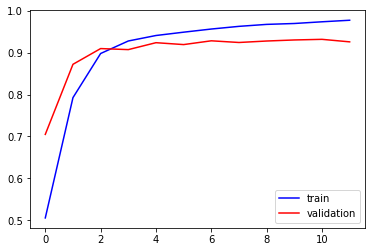

In [18]:
plt.plot(history.history['accuracy'],c='b',label='train')
plt.plot(history.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

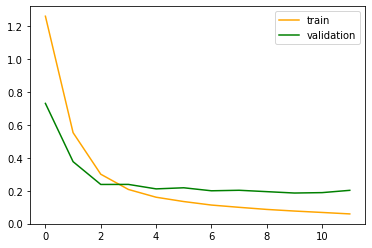

In [19]:
plt.plot(history.history['loss'],c='orange',label='train')
plt.plot(history.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

In [20]:
X_test=df_test['Text']
Y_test=df_test.Emotion.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')

Y_test_f=to_categorical(Y_test)

X_test_pad.shape



(2000, 80)

In [21]:
Y_test_f[:7]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [30]:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 9s 135ms/step - loss: 0.2148 - accuracy: 0.9250


[0.214819997549057, 0.925000011920929]

In [25]:
from sklearn.metrics import classification_report

In [31]:
Y_pred = model.predict(X_test_pad)

In [37]:
model.save('/content/drive/MyDrive/учеба/dataanal/nlp/emotions/emotionsmodel.h5')

In [ ]:
изменим модель

In [56]:
model2 = Sequential()

model2.add(Embedding(15212,64,input_length=80))

model2.add(Flatten())

model2.add(Dense(64,activation='sigmoid'))

model2.add(Dense(6, activation='softmax'))

In [57]:
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
history2=model2.fit(X_train_pad,Y_train_f,epochs=12,validation_data=(X_val_pad,Y_val_f))

Epoch 1/12
500/500 [==============================] - 10s 20ms/step - loss: 1.3555 - accuracy: 0.4988 - val_loss: 0.9366 - val_accuracy: 0.6910
Epoch 2/12
500/500 [==============================] - 9s 19ms/step - loss: 0.5237 - accuracy: 0.8449 - val_loss: 0.5010 - val_accuracy: 0.8370
Epoch 3/12
500/500 [==============================] - 10s 19ms/step - loss: 0.1822 - accuracy: 0.9503 - val_loss: 0.4411 - val_accuracy: 0.8575
Epoch 4/12
500/500 [==============================] - 9s 18ms/step - loss: 0.0807 - accuracy: 0.9805 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 5/12
500/500 [==============================] - 10s 19ms/step - loss: 0.0440 - accuracy: 0.9893 - val_loss: 0.4814 - val_accuracy: 0.8460
Epoch 6/12
500/500 [==============================] - 9s 19ms/step - loss: 0.0291 - accuracy: 0.9936 - val_loss: 0.5287 - val_accuracy: 0.8435
Epoch 7/12
500/500 [==============================] - 10s 19ms/step - loss: 0.0218 - accuracy: 0.9951 - val_loss: 0.5608 - val_accuracy: 0.

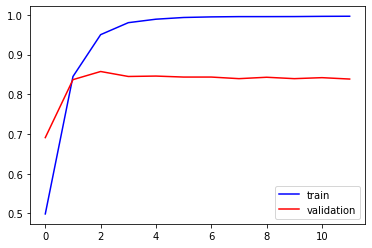

In [59]:
plt.plot(history2.history['accuracy'],c='b',label='train')
plt.plot(history2.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

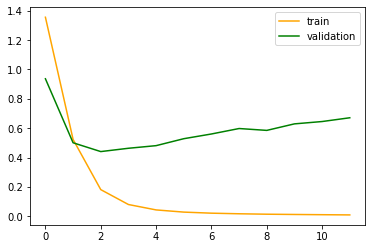

In [60]:
plt.plot(history2.history['loss'],c='orange',label='train')
plt.plot(history2.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

In [61]:
model2.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.8300


[0.7190438508987427, 0.8299999833106995]

In [ ]:
Таким образом первоначальная LSTM модель показывает лучшие результаты 